# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import yaml

from shapely import box

from quantum_electron.electron_counter import FullModel
from quantum_electron.schrodinger_solver import find_minimum_location, make_potential
from quantum_electron.utils import r2xy, xy2r
from zeroheliumkit.src.importing import Reader_GDS
from zeroheliumkit import Structure
from zeroheliumkit.fem import *
from zeroheliumkit.fem import FieldAnalyzer
from zeroheliumkit.src.settings import  *

%matplotlib inline
%config InlineBackend.figure_format='retina'

colorlist = [RED,BLUE, GRAY, YELLOW2,  GREEN, DARKGRAY]

In [3]:
import sys
print(sys.version)
print(sys.executable)

3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
C:\Users\LyonLab\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe


# GDS File Reading

I opened your dxf in Klayout and re-saved it as a GDS because that format is easier to import into our FEM package. 
Uncomment the plotting line to view the layers in a pop up window.

In [4]:
file = Reader_GDS('./SandiaCCD.gds')
file.import2zhk("TOP")
file.plot()

./SandiaCCD.gds // Layers in cell 'TOP': {28, 22}


Here I use the imported geometries to build up a Structure object layer by layer. I make both the entire chip (device) and a cropped version (devCrop). Only the cropped version is actually necessary, but if you are playing with the note book, it may be useful to look at both. 

I also add an extra layer "wafer" that is for the sapphire wafer.

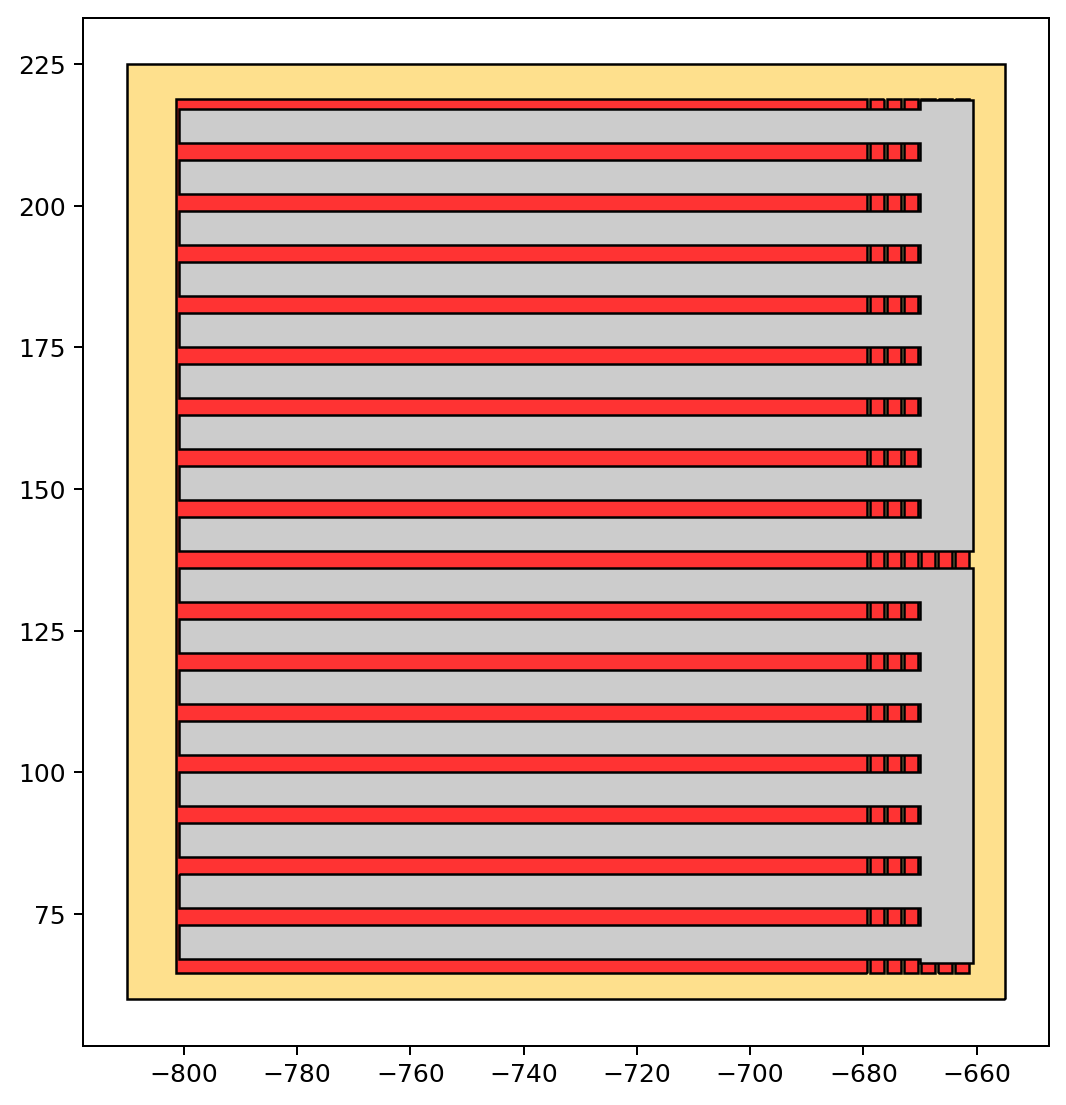

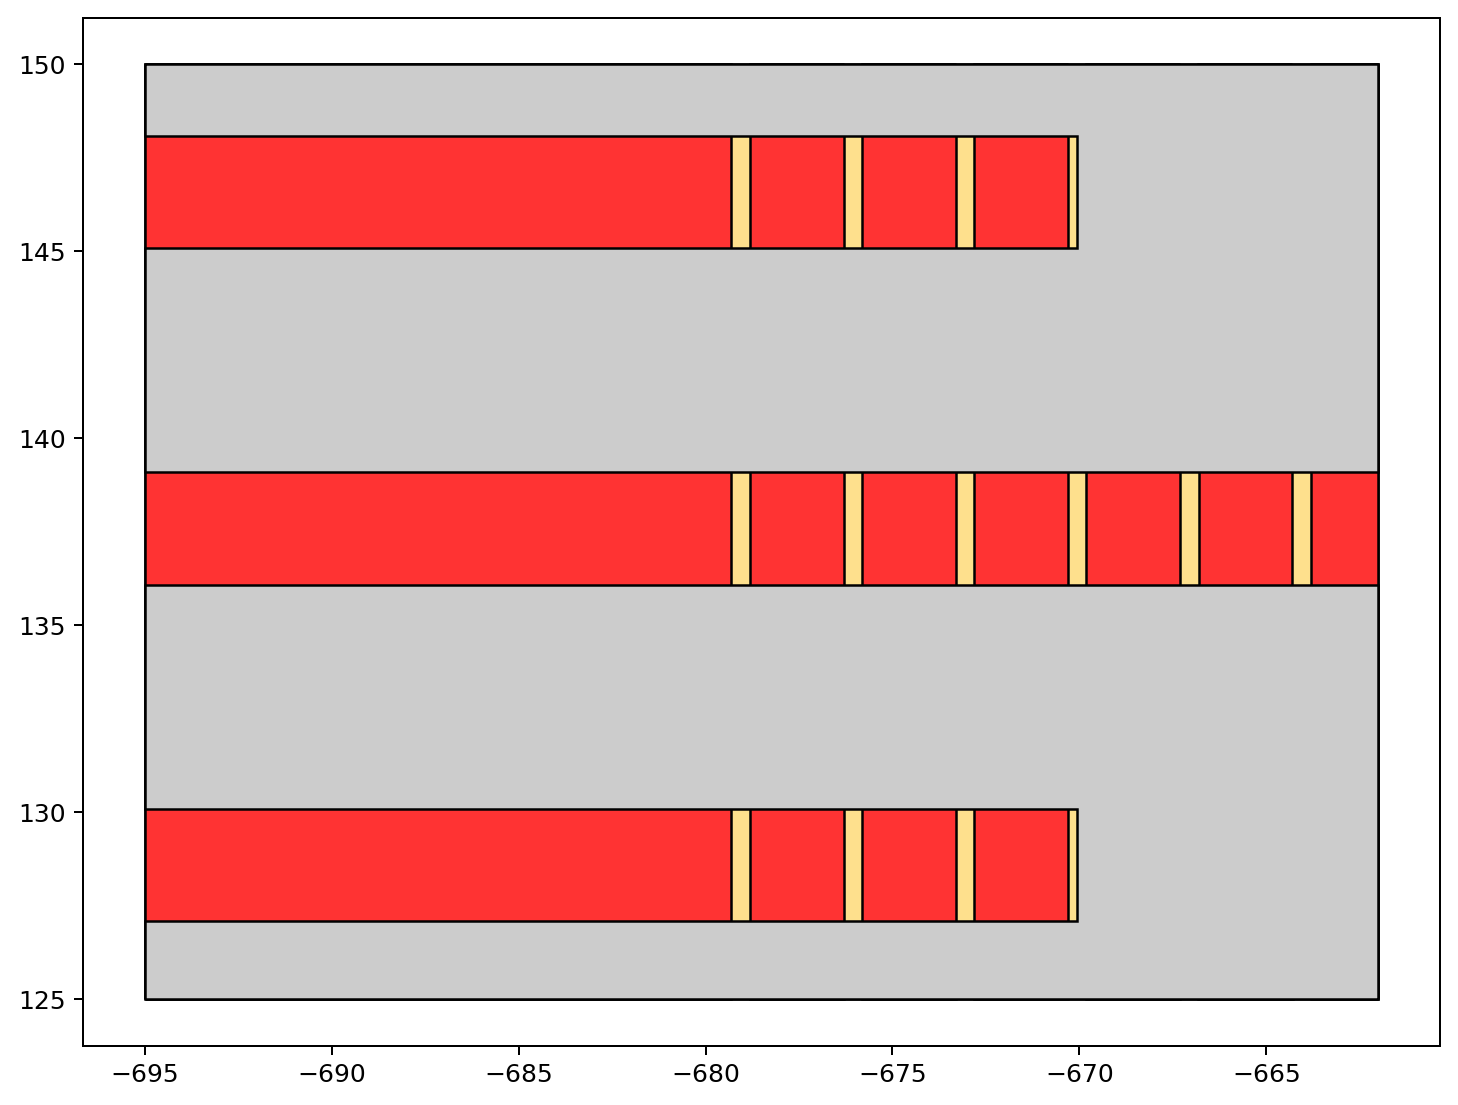

In [5]:
# Full Device Version
device = Structure()
device.add_layer('bottom',file.geometries['L22'])
device.add_layer('top',file.geometries['L28'])
device.add_layer('wafer',box(-810,60,-655,225))
device.quickplot({'wafer':YELLOW2,'bottom':RED,'top':GRAY,'anchors':BLUE})
plt.show()

# Cropped Version
devCrop = Structure()
devCrop.add_layer('bottom',file.geometries['L22'])
devCrop.add_layer('top',file.geometries['L28'])
devCrop.add_layer('wafer',box(-810,60,-655,225))
devCrop = devCrop.crop_all(box(-695,125,-662,150))

devCrop.quickplot({'wafer':YELLOW2,'bottom':RED,'top':GRAY,'anchors':BLUE})
plt.show()

# View the Electrode indicies

Here I plot the metal layers with the flag "show_idx" set to true. These indicies are useful for know when setting up the FEM files in the upcoming steps.

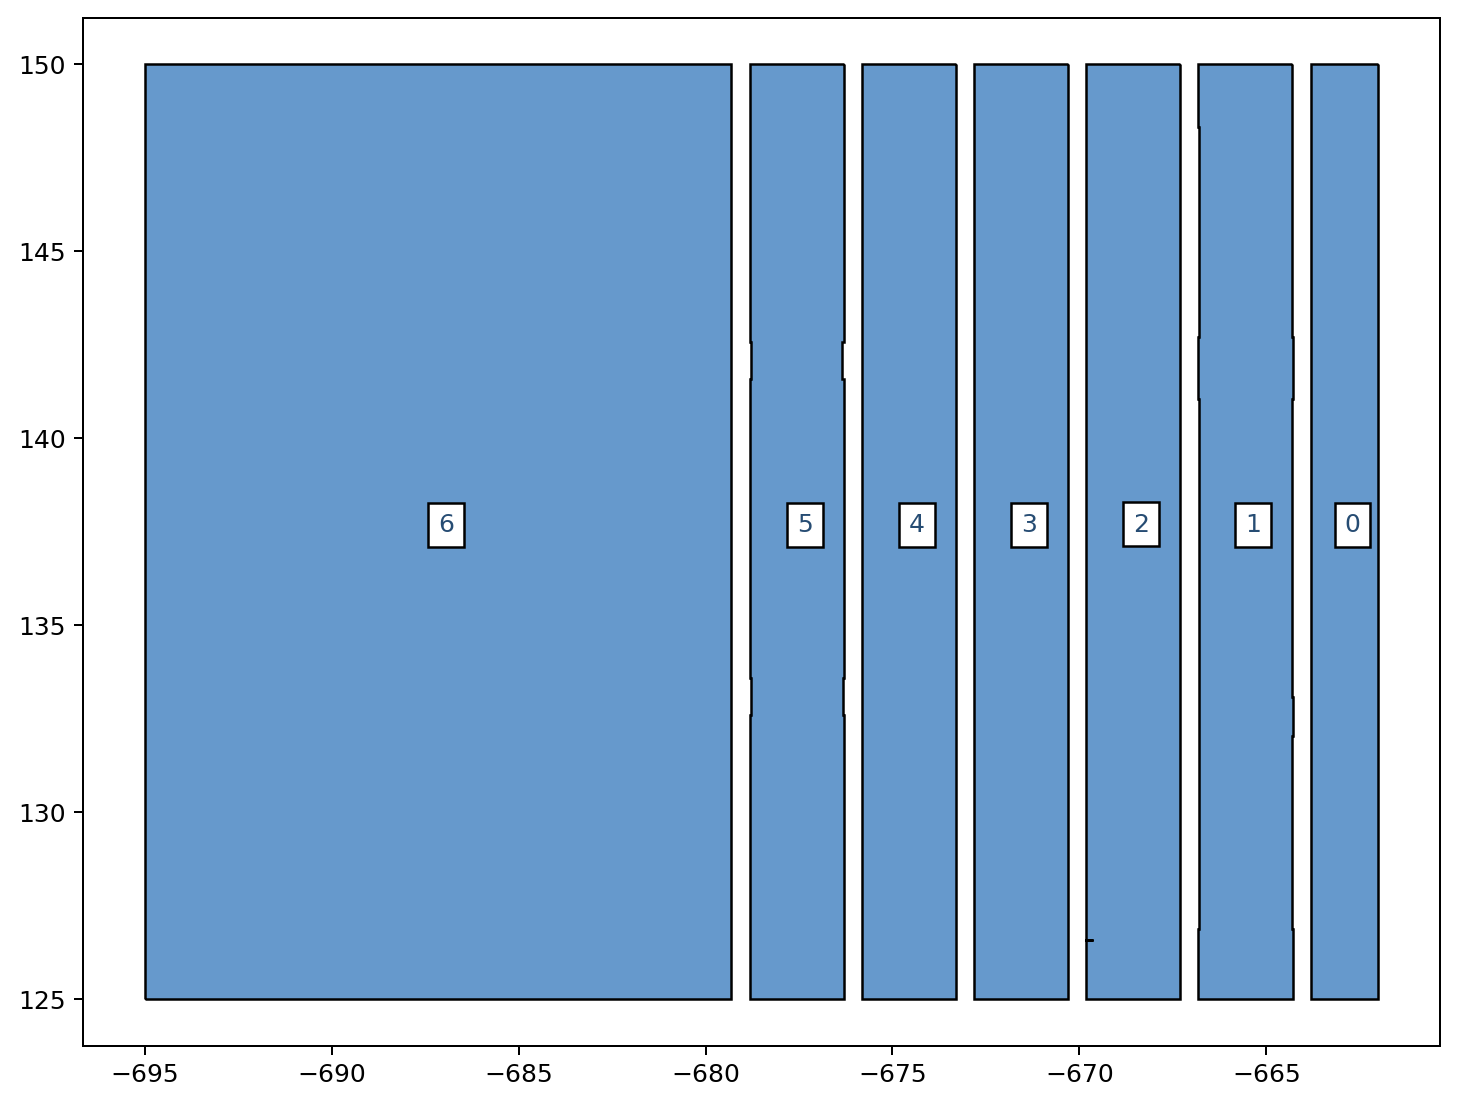

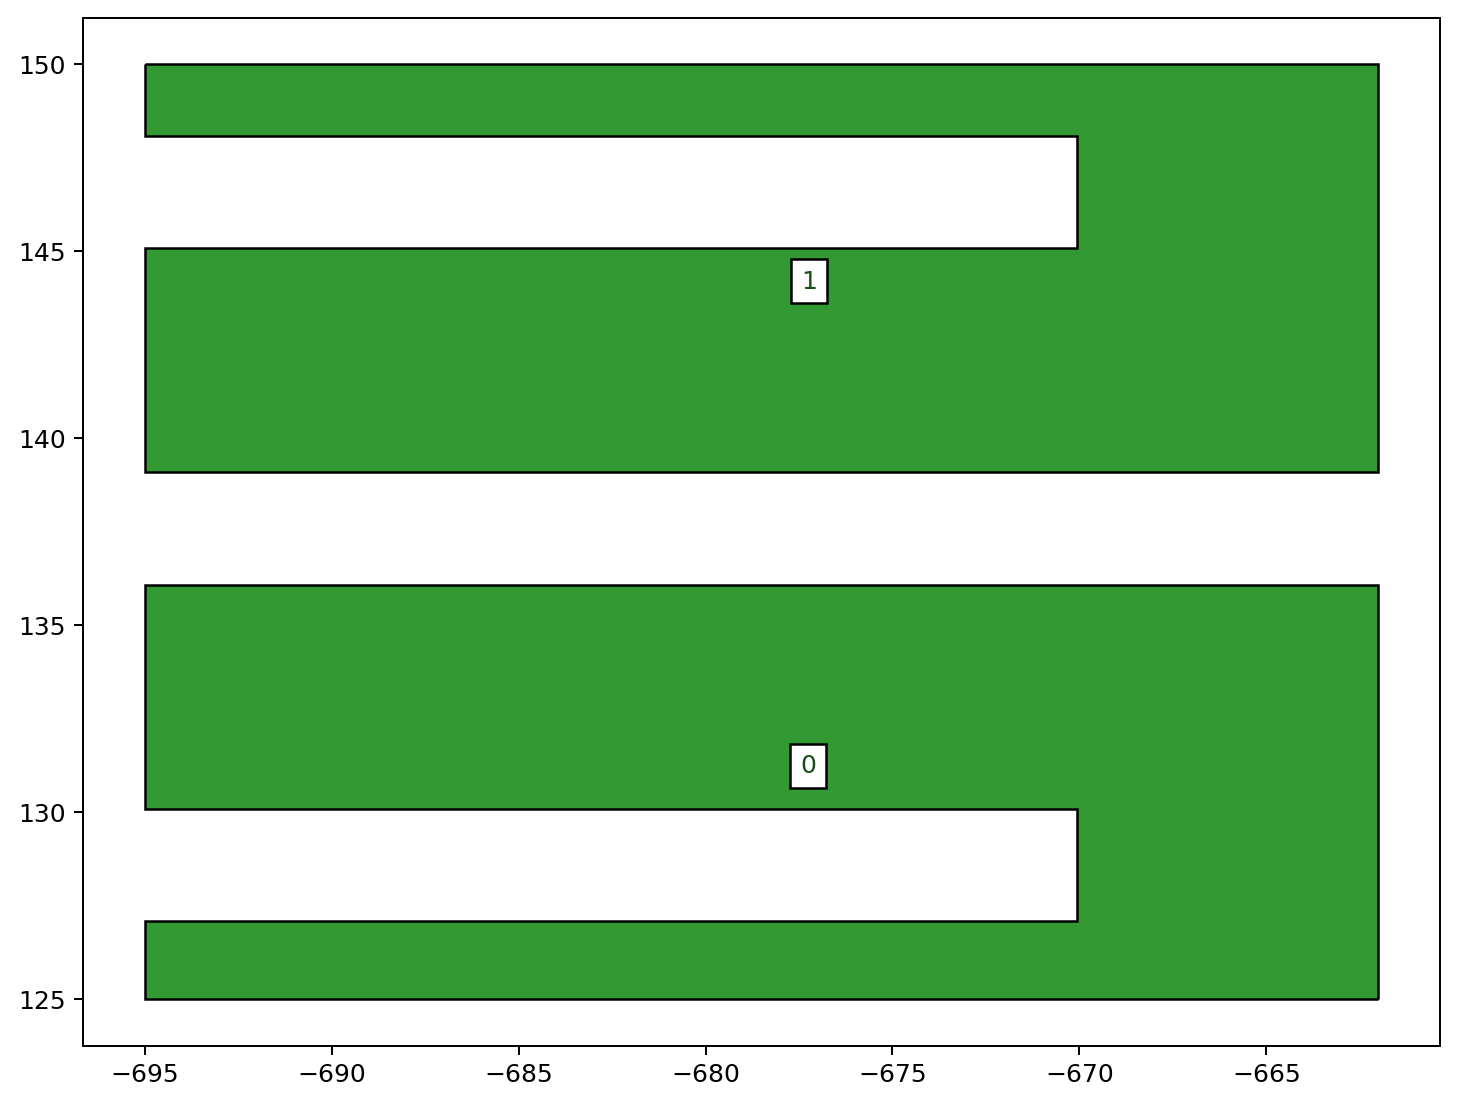

In [31]:
#Bottom Electrodes
fig = plt.figure(1, figsize=SIZE_L, dpi=90)
ax = fig.add_subplot(111)
devCrop.plot(ax=ax, layer=["bottom"], color=[BLUE,YELLOW],show_idx=True)
ax.set_aspect('equal')
plt.show()

#Top Electrodes
fig = plt.figure(1, figsize=SIZE_L, dpi=90)
ax = fig.add_subplot(111)
devCrop.plot(ax=ax, layer=["top"], color=[GREEN,YELLOW],show_idx=True)
ax.set_aspect('equal')
plt.show()

# Create the Config Dictionaries

The extrude_config dict tells the FEM both the material properties and 3D dimensions/locations of the electrodes.

The electrodes_config dict tells the FEM which separate geometries belong to which electrode labels. 

The mesh_params defines the mesh density regions. Areas of interest should be in the fine region. The fine region should be nested inside the medium region.

In [32]:
# Useful variables for thicknesses (in um)
d_metal1 = 0.9    # bottom metal
d_metal2 = 0.27   # top meteal
d_diel   = 0.96   
d_vac    = 10
d_He     = d_diel + d_metal2
d_total  = d_metal1 + d_He

""" 
extrude_config: 
key - gmsh layer name
item - gmshLayer_info dict: 
       (geometry layer, z0, thickness, Physical Vol Name, CUT gmsh layer=None, forConstruction=False)
"""
# When the final argument (forConstruction) is given as a tuple of gmsh layers, these layers will be cut out from the current layer.
# For example, below the helium layer should not overlap the insulator and top metal layer, so these layers are cut from it
extrude_config = {
    'bottom':        gmshLayer_info('bottom' , 0                , d_metal1   , 'METAL'),
    'ins':           gmshLayer_info('top'    , d_metal1         , d_diel     , 'DIELECTRIC'),
    'top':           gmshLayer_info('top'    , d_metal1+d_diel  , d_metal2   , 'METAL'),
    'helium':        gmshLayer_info('wafer'  , d_metal1         , d_He       , 'HELIUM', ('ins','top')),
    'vacuum':        gmshLayer_info('wafer'  , d_total          , d_vac      , 'VACUUM', ('ins', 'top'))
}

""" 
electrodes_config: 
key - physicalSurface name
item - physSurface_info dict:
       (geometry layer, electrode idx in geometry layer, gmsh layer)
"""
electrodes_config = {
    'CCD3':            physSurface_info('bottom', [0], 'bottom'),
    'CCD2':            physSurface_info('bottom', [1], 'bottom'),
    'CCD1':            physSurface_info('bottom', [2], 'bottom'),
    'DR3':             physSurface_info('bottom', [3], 'bottom'),
    'DR2':             physSurface_info('bottom', [4], 'bottom'),
    'Dr1':             physSurface_info('bottom', [5], 'bottom'),
    'Reservoir':       physSurface_info('bottom', [6], 'bottom'),
    'TopMetal':        physSurface_info('top', [0,1], 'top'),
}


""" 
mesh_params is a list of dicts.
Each dict is for a different density region (here fine and medium) given of the form:
Thickness : width (in um) of the transition from this region's density to the outer layers density,
VIn       : density scale inside the region
VOut      : density scale outside the region
box       : coordinates of the boundary given as [x0,x1,y0,y1,z0,z1]
"""
mediumregion_box = [-695, -662, 125, 150, -0.7, 6]
fineregion_box = [-695, -662, 135, 140, -0.1, 4.5]

scale = 10
mesh_params = [{"Thickness": 4, "VIn": scale * 0.1, "VOut": .5*scale, "box": mediumregion_box},
               {"Thickness": 2, "VIn": scale * 0.05, "VOut": .5*scale, "box": fineregion_box}
              ]

# Check the mesh

By setting dim=2 in the create_mesh argument, you can get a sense of whether your mesh is too coarse or dense quickly before fully committing to a 3d mesh. This step is optional, but useful when playing with the prior step.

In [33]:
mshID = 'Sandia'
meshMKR =  GMSHmaker(layout=devCrop, 
                     extrude_config=extrude_config, 
                     electrodes_config=electrodes_config, 
                     mesh_params=mesh_params)
#meshMKR.disable_consoleOutput()
meshMKR.create_geo(mshID )
meshMKR.create_mesh(mshID, dim=2)
meshMKR.open_gmsh()
meshMKR.finalize()

on 0: mesh is constructed                                                       
on 0: mesh saved                                                                
Gmsh generation  |███| 1/1 [100%] in 0.4s (2.55/s)                              


# Create the Mesh

With the dim=3, this cell will generate the normal 3D mesh file as defined by the config dictionaries created two cells above.

In [34]:
mshID = 'Sandia'
meshMKR =  GMSHmaker(layout=devCrop, 
                     extrude_config=extrude_config, 
                     electrodes_config=electrodes_config, 
                     mesh_params=mesh_params)
#meshMKR.disable_consoleOutput()
meshMKR.create_geo(mshID )
meshMKR.create_mesh(mshID, dim=3)
meshMKR.open_gmsh()
meshMKR.finalize()

on 0: mesh is constructed                                                       
on 0: mesh saved                                                                
Gmsh generation  |███| 1/1 [100%] in 1.3s (0.77/s)                              


# Save the freeFEM config to a yaml

Mesh generation and all of the prior steps can be time consuming, so this step will allow you save the progress thus far to a YAML for later use without needing to rerun everything.

Also this file contains a key 'extract_opt'. This is a list of 2d grids from which you want to extract information. Below I am extracting voltages along only one 2D area.

In [35]:
He_level = extrude_config['helium']['z'] + extrude_config['helium']['thickness']

var_eps = {
        'DIELECTRIC': 11.0,
        'METAL': 1.0,
        'HELIUM': 1.057,
        'VACUUM': 1.0,
}

# The extract_results arguments for each item in the extract_opt list are given as:
# (quantityTypeString, PlaneString, (x0,x1,numSteps), (y0,y1,numSteps), z0, SavingfileName)
ff_config ={
    'meshfile': mshID,
    'dielectric_constants': var_eps,
    'ff_polynomial': 2,
    'extract_opt': [extract_results('phi', 'xy', (-695, -662, 301), (135, 140, 1001), He_level,'Sandia'),
                    ],
    'physicalSurfaces': {k: v.get('group_id') for (k, v) in meshMKR.physicalSurfaces.items()},
    'physicalVolumes': {k: v.get('group_id') for (k, v) in meshMKR.physicalVolumes.items()}
}

with open(r'config.yaml', 'w') as file:
    documents = yaml.safe_dump(ff_config, file)

# Create the .edp file

Finally, this cell created the final output, an edp file. These can be run from the terminal by navigating to the folder and running "freefem++ myFile.edp"

In [36]:
with open(r'config.yaml', 'r') as file:
    config = yaml.safe_load(file)

pyff = FreeFEM(config=config,
               dirname='./',
               run_from_notebook=False)